# Hierarchical Predator Prey modelling

The Lotka-Volterra predator-prey model is the archetypical model for dynamical systems, depicting the fluctuating population development of the dynamical system. 
It is simple enough to fit parameters and estimate their uncertainty in a single replicate. But what if there was some environmental fluctuation we wanted 

In [1]:
import numpy as np
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt

from pymob import Config
from pymob.inference.scipy_backend import ScipyBackend
from pymob.sim.parameters import Param
from pymob.sim.config import Modelparameters
from pymob.solvers.diffrax import JaxSolver
from pymob.inference.analysis import plot_pair

In [2]:
# import case study and simulation

config = Config()
config.case_study.package = "../.."
config.case_study.name = "lotka_volterra_case_study"
config.case_study.scenario = "test_hierarchical"
config.case_study.simulation = "HierarchicalSimulation"
config.import_casestudy_modules(reset_path=True)

from sim import HierarchicalSimulation

sim = HierarchicalSimulation(config)
sim.initialize_from_script()


Inserted './../..' in PATH at index=0
Inserted './../../lotka_volterra_case_study' in PATH at index=0


## Setting up the data variability structure



In [3]:
sim.config.model_parameters.alpha_species = Param(
    value=0.5, free=True, hyper=True,
    dims=('rabbit_species','experiment'),
    # take good care to specify hyperpriors correctly. 
    # Dimensions are broadcasted following the normal rules of 
    # numpy. The below means, in dimension one, we have two different
    # assumptions 1, and 3. Dimension one is the dimension of the rabbit species.
    # The specification loc=[1,3] would be understood as [[1,3]] and
    # be understood as the experiment dimension. Ideally, the dimensionality
    # is so low that you can be specific about the priors. I.e.:
    # scale = [[1,1,1],[3,3,3]]. This of course expects you know about
    # the dimensionality of the prior (i.e. the unique coordinates of the dimensions)
    prior="norm(loc=[[1],[3]],scale=0.1)" # type: ignore
)
# prey birth rate
# to be clear, this says each replicate has a slightly varying birth
# rate depending on the valley where it was observed. Seems legit.
sim.config.model_parameters.alpha = Param(
    value=0.5, free=True, hyper=False,
    dims=('id',),
    prior="lognorm(s=0.1,scale=alpha_species[rabbit_species_index, experiment_index])" # type: ignore
)

# re initialize the observation with
sim.define_observations_replicated_multi_experiment(n=120) # type: ignore
sim.coordinates["time"] = np.arange(12)

# This is a mistake 💥 as we will learn later on ('hierarchical_model_varying_y0.ipynb')
y0 = sim.parse_input("y0", drop_dims=["time"])
sim.model_parameters["y0"] = y0

Small teaser, we define the initial values from the noisy observations! Knowing the true starting values is essential, for correctly fitting the model. But let's go step by step. In the next part of the tutorial we'll take a look at varying initial values.

## Sample from the nested parameter distribution

To simply generate some parameter samples from a distribution, the ScipyBackend has been set up.

In [4]:
inferer = ScipyBackend(simulation=sim)

theta = inferer.sample_distribution()

alpha_samples_cottontail = theta["alpha"][sim.observations["rabbit_species"] == "Cottontail"]
alpha_samples_jackrabbit = theta["alpha"][sim.observations["rabbit_species"] == "Jackrabbit"]

alpha_cottontail = np.mean(alpha_samples_cottontail)
alpha_jackrabbit = np.mean(alpha_samples_jackrabbit)

# test if the priors that were broadcasted to the replicates 
# match the hyperpriors
np.testing.assert_array_almost_equal(
    [alpha_cottontail, alpha_jackrabbit], [1, 3], decimal=1
)

In [5]:
theta

{'alpha_species': array([[1.03455842, 1.08216181, 1.03304371],
        [2.86968428, 3.09053559, 3.04463746]]),
 'alpha': array([0.98047254, 1.09645966, 1.07297153, 1.06544008, 1.03750305,
        1.09269376, 0.96110586, 1.01784098, 0.98586363, 1.0984052 ,
        1.03867608, 1.00474021, 0.95674713, 1.00828963, 1.03540112,
        1.00643501, 1.17748531, 1.14413297, 0.78887961, 0.85647801,
        2.81996594, 2.75105087, 2.93165267, 2.9327314 , 3.54658756,
        2.56767274, 2.76334393, 3.52006402, 3.06139996, 3.06641263,
        2.72590744, 2.43365562, 2.91814602, 2.90113902, 2.53822955,
        2.68016765, 2.84908431, 2.61098319, 2.84162201, 2.89721612,
        1.08601968, 1.02873671, 1.14836079, 1.18302819, 1.11744581,
        0.99714179, 1.16430687, 1.02923594, 1.18160866, 0.97217639,
        1.18578789, 1.0799928 , 0.95512394, 1.04872042, 1.08803242,
        1.11208858, 0.98092616, 0.96872299, 1.10397707, 1.0328126 ,
        3.16418325, 3.33441202, 2.62076345, 3.17016367, 3.493168

Next up we use the samples to generate some trajectories and add Poisson noise on top of the data

In [6]:
sim.solver = JaxSolver
sim.model_parameters["parameters"] = sim.config.model_parameters.value_dict
sim.dispatch_constructor()
e = sim.dispatch(theta=theta)
e()

rng = np.random.default_rng(1)

# add noise. 
obs = e.results
obs.rabbits.values = rng.poisson(e.results.rabbits+1e-6)
obs.wolves.values = rng.poisson(e.results.wolves+1e-6)


sim.observations = obs
sim.config.data_structure.rabbits.observed = True
sim.config.data_structure.wolves.observed = True

# update settings
sim.config.case_study.scenario = "test_hierarchical_presimulated"
sim.config.create_directory("scenario", force=True)
sim.config.create_directory("results", force=True)
sim.config.model_parameters.beta.value = np.round(theta["beta"], 4)
sim.config.model_parameters.alpha.value = np.round(theta["alpha"], 2)
sim.config.model_parameters.alpha_species.value = np.round(theta["alpha_species"],2)

# store simulated results
sim.save_observations("simulated_data_hierarchical_species_year.nc", force=True)

# store settings
sim.config.save(force=True)

/home/flo-schu/projects/pymob/pymob/simulation.py:399: UserWarning: The number of ODE states was not specified in the config file [simulation] > 'n_ode_states = <n>'. Extracted the return arguments ['dprey_dt', 'dpredator_dt'] from the source code. Setting 'n_ode_states=2.
  warnings.warn(


Scenario directory exists at '/home/flo-schu/projects/pymob/case_studies/lotka_volterra_case_study/scenarios/test_hierarchical_presimulated'.
Results directory exists at '/home/flo-schu/projects/pymob/case_studies/lotka_volterra_case_study/results/test_hierarchical_presimulated'.


## Defining an incorrect error distribution 💥

To see how to diagnose problems in a model, we deliberately specify an incorrect distribution that looks innocuous, but has two severe problems. One is obvious, the other one is a sneaky one.
Below is a conventionally used way to define error models. We center a lognormal error model around the means of the distribution. 

In [7]:
sim.config.error_model.rabbits = "lognorm(scale=rabbits+EPS, s=0.1)"
sim.config.error_model.wolves = "lognorm(scale=wolves+EPS, s=0.1)"
sim.dispatch_constructor()
sim.set_inferer("numpyro")


First we simply try to fit the distribution, but run into a problem, **because the lognormal distribution does not support zero values**. We get a warning from the `check_log_likelihood` function from the numpyro backend. If we are unsure if our model is specified incorrectly, it is a good idea to use that function.

In [8]:
try:
    sim.inferer.run()
    raise AssertionError(
        "This model should fail, because there are zero values in the"+
        "observations, hence the log-likelihood becomes nan, because there"+
        "is no support for the values"
    )
except RuntimeError:
    # check likelihoods of rabbits     
    loglik = sim.inferer.check_log_likelihood(theta)
    nan_liks = np.isnan(loglik[2]["rabbits_obs"]).sum()
    assert nan_liks > 0


     Trace Shapes:          
      Param Sites:          
     Sample Sites:          
alpha_species dist   2   3 |
             value   2   3 |
        alpha dist     120 |
             value     120 |
         beta dist         |
             value         |
  rabbits_obs dist 120  12 |
             value 120  12 |
   wolves_obs dist 120  12 |
             value 120  12 |


/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:587: UserWarning: Site rabbits_obs: Out-of-support values provided to log prob method. The value argument should be within the support.
  mcmc.run(next(keys))
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:587: UserWarning: Site wolves_obs: Out-of-support values provided to log prob method. The value argument should be within the support.
  mcmc.run(next(keys))
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:853: UserWarning: Log-likelihoods ['rabbits_obs', 'wolves_obs'] contained NaN or inf values. The gradient based samplers will not be able to sample from this model. Make sure that all functions are numerically well behaved. Inspect the model with `jax.debug.print('{}',x)` https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html#exploring-debug-callback Or look at the functions step by step to find the position where jnp.grad(func)(x) evaluates to NaN
  warnings.warn(


This problem can be cured by simply incrementing the observations by a small value, but we can go deeper and investigate if the error model is actually a fitting description of the data. For this we generate some prior predictions to look at further problems in the model

In [9]:
idata = sim.inferer.prior_predictions(n=100)

# first we test if numpyro predictions also match the specified priors
alpha_numpyro = idata.prior["alpha"].mean(("chain", "draw"))
alpha_numpyro_cottontail = np.mean(alpha_numpyro.values[sim.observations["rabbit_species"] == "Cottontail"])
alpha_numpyro_jackrabbit = np.mean(alpha_numpyro.values[sim.observations["rabbit_species"] == "Jackrabbit"])

# test if the priors that were broadcasted to the replicates 
# match the hyperpriors
np.testing.assert_array_almost_equal(
    [alpha_numpyro_cottontail, alpha_numpyro_jackrabbit], [1, 3], decimal=1
)

Next we plot the likelihoods of the different data variables. This helps to diagnose problems with multiple endpoints

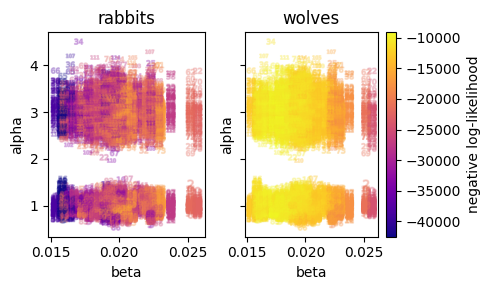

In [10]:
loglik = idata.log_likelihood.sum(("id", "time"))
fig = plot_pair(idata.prior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/bad_likelihood.png")

The problem is: due to the large scale differences in rabbits and wolves, the log-likelihoods end up very differently. This has to do with heteroskedasticity. The lognormal density becomes smaller at larger values to maintain the requirement that probability distributions integrate to 1. Here the wolves data variable will basically be meaningless, because the rabbits data variable is at such a high scale Scaling alone also does not resolve this problem, because due to the dynamic of the data variables, larger values will have a higher weight. This is not right. 🤯

## Defining a correct error distribution for the data by using a residual error model

As it turns out, the residuals of a poisson distributed variable can be transformed to a standard normal distributon by dividing with the square root of the random variables mean. 

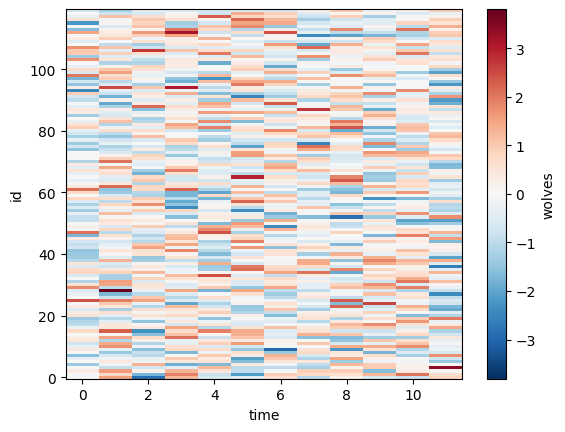

In [15]:
scaled_residuals = (sim.observations - e.results)/np.sqrt(e.results+1e-6)
scaled_residuals.wolves.plot()

The heatmap plot shows us that the residual are equally distributed through time and id. This looks perfect. This means there is no underlying dynamic governing the residuals. In pymob, we specify this relationship **by providing a transform of the observations of our error model**.

In [11]:
sim.config.error_model.rabbits = "norm(loc=0, scale=1, obs=(obs-rabbits)/jnp.sqrt(rabbits+1e-6))"
sim.config.error_model.wolves = "norm(loc=0, scale=1, obs=(obs-wolves)/jnp.sqrt(wolves+1e-6))"

sim.dispatch_constructor()
sim.set_inferer("numpyro")

/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:937: UserWarning: Cannot make predictions of observations from normalized observations (residuals). Please provide an inverse observation transform: e.g. `sim.config.error_model['rabbits'].obs_inv = ...`.residuals are denoted as 'res'. See Lotka-volterra case study for an example. 
  warnings.warn(
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:937: UserWarning: Cannot make predictions of observations from normalized observations (residuals). Please provide an inverse observation transform: e.g. `sim.config.error_model['wolves'].obs_inv = ...`.residuals are denoted as 'res'. See Lotka-volterra case study for an example. 
  warnings.warn(


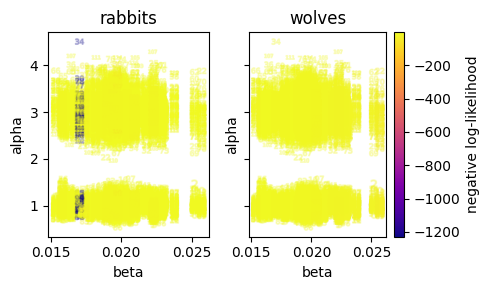

In [17]:
idata = sim.inferer.prior_predictions(n=100)

# no nan problems any longer in the likelihood
loglik = sim.inferer.check_log_likelihood(theta)
nan_liks_rabbits = np.isnan(loglik[2]["rabbits_obs"]).sum()
nan_liks_wolves = np.isnan(loglik[2]["wolves_obs"]).sum()
np.testing.assert_array_equal([nan_liks_wolves, nan_liks_rabbits], [0,0])

# plot likelihoods
loglik = idata.log_likelihood.mean(("id", "time"))
fig = plot_pair(idata.prior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/good_likelihood.png")

Next we look at the problem from a slightly different angle. By splitting the likelihood between different ids (in case of a hierarchical model this is possible, we can look at problematic samples.)

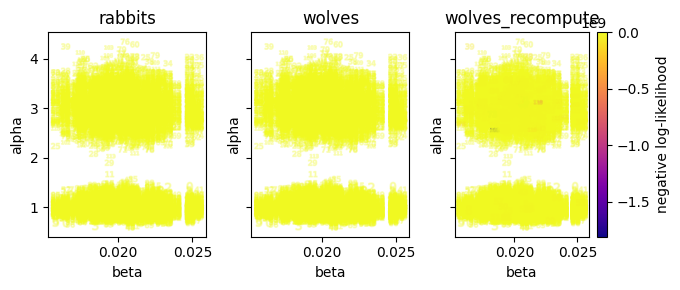

In [19]:
from scipy.stats import norm

# the 2nd visualization is actually not so helpful, because it rather focuses on
# the individual replicates and not so much on the dynamics of the parameters

idata = sim.inferer.prior_predictions(n=100, seed=132)

resid = (idata.prior_predictive.wolves - idata.observed_data.wolves)/np.sqrt(idata.prior_predictive.wolves)
loglik = norm(0,1).logpdf(resid)

idata.log_likelihood["wolves_recompute"] = (("chain", "draw","id", "time"), loglik)

loglik = idata.log_likelihood.sum(("time"))
# prior = idata.prior.rename({"alpha_dim_0":"id"})
fig = plot_pair(idata.prior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/better_likelihood_questionmark.png")

Overall we conclude that it is way better to use residuals for the error modelling, because if the residuals are described correctly, this results in an equally distributed likelihood of the errorrs.

In addition, the reparameterization of the error distribution has seemed to help the NUTS sampler.

In [12]:
# fitting with SVI seems to work okay
sim.config.inference_numpyro.svi_iterations = 2_000
sim.config.inference_numpyro.svi_learning_rate = 0.005
sim.config.inference_numpyro.gaussian_base_distribution = True
sim.config.jaxsolver.max_steps = 1e5
sim.config.jaxsolver.throw_exception = False
sim.config.inference_numpyro.init_strategy = "init_to_median"
sim.dispatch_constructor()
sim.set_inferer("numpyro")

sample_nuts = False
if sample_nuts:
    sim.config.inference_numpyro.kernel = "nuts"
    sim.inferer.run()
    sim.inferer.store_results() # type: ignore
else:
    sim.inferer.load_results()

idata_nuts = sim.inferer.idata.copy()
az.summary(sim.inferer.idata.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.963,0.018,0.928,0.995,0.000,0.000,3182.0,1572.0,NaN
alpha[1],1.085,0.015,1.055,1.112,0.000,0.000,3676.0,1873.0,NaN
alpha[2],1.026,0.019,0.994,1.065,0.000,0.000,2785.0,1505.0,NaN
alpha[3],1.051,0.019,1.017,1.086,0.000,0.000,3544.0,1823.0,NaN
alpha[4],1.022,0.014,0.996,1.049,0.000,0.000,3434.0,1287.0,NaN
...,...,...,...,...,...,...,...,...,...
"wolves_res[119, 7]",0.159,0.135,-0.088,0.420,0.002,0.002,3380.0,1368.0,NaN
"wolves_res[119, 8]",0.911,0.121,0.690,1.144,0.002,0.001,3380.0,1368.0,NaN
"wolves_res[119, 9]",-0.200,0.099,-0.380,-0.010,0.002,0.001,3380.0,1368.0,NaN
"wolves_res[119, 10]",0.179,0.087,0.021,0.347,0.001,0.001,3380.0,1368.0,NaN


array([[<Axes: title={'center': 'alpha_species'}>,
        <Axes: title={'center': 'alpha_species'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

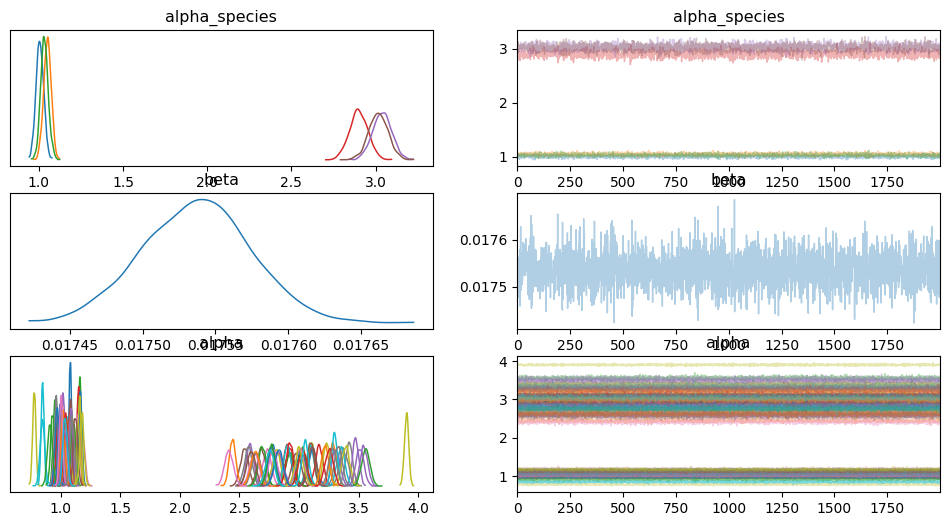

In [23]:

az.plot_trace(idata_nuts, var_names=("alpha_species", "beta", "alpha"))

The parameters are perfectly recovered. We have a true beta of 0.1765 and the fitted beta is 0.1755, where the distribution contains the true parameter, although the mode is a bit off. I'm curious if the residual error distribution was too wide or too narrow would have made the posterior beta distribution wider. Also in a second iteration, the priors for estimating should be made less informative, to see if the inference still works. But overall this has been a success. We have no divergences, perfect r_hat and high effective sampling size. So things look good

In [24]:
theta["beta"]

0.017648710084435453

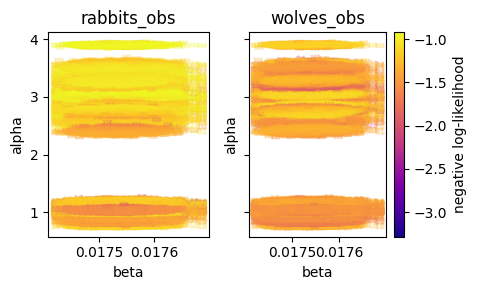

In [25]:
posterior = idata_nuts.posterior[["alpha", "beta"]].rename({"alpha_dim_0": "id"})
loglik = idata_nuts.log_likelihood.mean(("time"))
fig = plot_pair(posterior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/posterior.png")

## Inspect fitted results from MCMC

                 Trace Shapes:          
                  Param Sites:          
                 Sample Sites:          
alpha_species_normal_base dist   2   3 |
                         value   2   3 |
        alpha_normal_base dist     120 |
                         value     120 |
         beta_normal_base dist         |
                         value         |
              rabbits_obs dist 120  12 |
                         value 120  12 |
               wolves_obs dist 120  12 |
                         value 120  12 |


100%|██████████| 2000/2000 [00:53<00:00, 37.43it/s, init loss: 12252.5215, avg. loss [1901-2000]: 4062.4299]
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:937: UserWarning: Cannot make predictions of observations from normalized observations (residuals). Please provide an inverse observation transform: e.g. `sim.config.error_model['rabbits'].obs_inv = ...`.residuals are denoted as 'res'. See Lotka-volterra case study for an example. 
  warnings.warn(
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:937: UserWarning: Cannot make predictions of observations from normalized observations (residuals). Please provide an inverse observation transform: e.g. `sim.config.error_model['wolves'].obs_inv = ...`.residuals are denoted as 'res'. See Lotka-volterra case study for an example. 
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[0]                         0.969  0.017   0.937    1.001        0.0   
alpha[1]                         1.083  0.016   1.054    1.114        0.0   
alpha[2]                         1.025  0.019   0.990    1.061        0.0   
alpha[3]                         1.048  0.018   1.015    1.081        0.0   
alpha[4]                         1.021  0.015   0.993    1.048        0.0   
...                                ...    ...     ...      ...        ...   
alpha_species[Cottontail, 2012]  1.028  0.011   1.008    1.048        0.0   
alpha_species[Jackrabbit, 2010]  2.908  0.018   2.876    2.943        0.0   
alpha_species[Jackrabbit, 2011]  3.047  0.017   3.015    3.081        0.0   
alpha_species[Jackrabbit, 2012]  3.054  0.014   3.028    3.081        0.0   
beta                             0.018  0.000   0.017    0.018        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
alpha

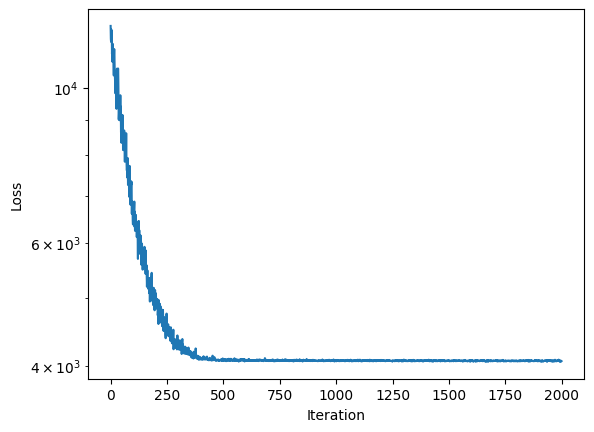

In [26]:
# fitting with SVI seems to work okay
sim.config.inference_numpyro.kernel = "svi"
sim.config.inference_numpyro.svi_iterations = 2_000
sim.config.inference_numpyro.svi_learning_rate = 0.005
sim.config.inference_numpyro.gaussian_base_distribution = True
sim.config.jaxsolver.max_steps = 1e5
sim.config.jaxsolver.throw_exception = False
sim.config.inference_numpyro.init_strategy = "init_to_median"
sim.dispatch_constructor()
sim.set_inferer("numpyro")
sim.inferer.run()
idata_svi = sim.inferer.idata.copy()

In [27]:
posteriors = xr.combine_by_coords([
    idata_svi.posterior.expand_dims("algorithm").assign_coords({"algorithm": ["svi"]}),
    idata_nuts.posterior.expand_dims("algorithm").assign_coords({"algorithm": ["nuts"]}),
    ], combine_attrs="drop"
)
posteriors


<xarray.Dataset>
Dimensions:                          (chain: 1, draw: 2000, alpha_dim_0: 120,
                                      alpha_normal_base_dim_0: 120,
                                      alpha_species_dim_0: 2,
                                      alpha_species_dim_1: 3,
                                      alpha_species_normal_base_dim_0: 2,
                                      alpha_species_normal_base_dim_1: 3,
                                      id: 120, time: 12,
                                      rabbits_res_dim_0: 120,
                                      rabbits_res_dim_1: 12,
                                      wolves_res_dim_0: 120,
                                      wolves_res_dim_1: 12, algorithm: 2,
                                      rabbit_species: 2, experiment: 3)
Coordinates: (12/17)
  * chain                            (chain) int64 0
  * draw                             (draw) int64 0 1 2 3 ... 1997 1998 1999
  * alpha_dim_0                      (alpha_dim_0) int64 0 1 2 3 ... 117 118 119
  * alpha_normal_base_dim_0          (alpha_normal_base_dim_0) int64 0 1 ... 119
  * alpha_species_dim_0              (alpha_species_dim_0) int64 0 1
  * alpha_species_dim_1              (alpha_species_dim_1) int64 0 1 2
    ...                               ...
  * rabbits_res_dim_1                (rabbits_res_dim_1) int64 0 1 2 ... 9 10 11
  * wolves_res_dim_0                 (wolves_res_dim_0) int64 0 1 2 ... 118 119
  * wolves_res_dim_1                 (wolves_res_dim_1) int64 0 1 2 ... 9 10 11
  * algorithm                        (algorithm) <U4 'nuts' 'svi'
  * rabbit_species                   (rabbit_species) <U10 'Cottontail' 'Jack...
  * experiment                       (experiment) <U4 '2010' '2011' '2012'
Data variables:
    alpha                            (algorithm, chain, draw, alpha_dim_0, id) float32 ...
    alpha_normal_base                (algorithm, chain, draw, alpha_normal_base_dim_0) float32 ...
    alpha_species                    (algorithm, chain, draw, alpha_species_dim_0, alpha_species_dim_1, rabbit_species, experiment) float32 ...
    alpha_species_normal_base        (algorithm, chain, draw, alpha_species_normal_base_dim_0, alpha_species_normal_base_dim_1) float32 ...
    beta                             (algorithm, chain, draw) float32 0.01757...
    beta_normal_base                 (algorithm, chain, draw) float32 -1.297 ...
    rabbits                          (algorithm, chain, draw, id, time) float32 ...
    rabbits_res                      (algorithm, chain, draw, rabbits_res_dim_0, rabbits_res_dim_1) float32 ...
    wolves                           (algorithm, chain, draw, id, time) float32 ...
    wolves_res                       (algorithm, chain, draw, wolves_res_dim_0, wolves_res_dim_1) float32 ...

/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:239: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "label_idxs" failed type inference due to: Untyped global name 'defaultdict': Cannot determine Numba type of <class 'type'>

File "../../../../../miniconda3/envs/damage-proxy/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py", line 244:
        def label_idxs():
            <source elided>
                sub_labels, sub_idxs, _, _ = plotter.labels_ticks_and_vals()
                labels_to_idxs = defaultdict(list)
                ^

  @conditional_jit(forceobj=True)


ValueError: Cannot add edge as dest node 508 not in nodes {258, 260, 496, 144, 146, 210, 20, 18, 17, 497, 410}

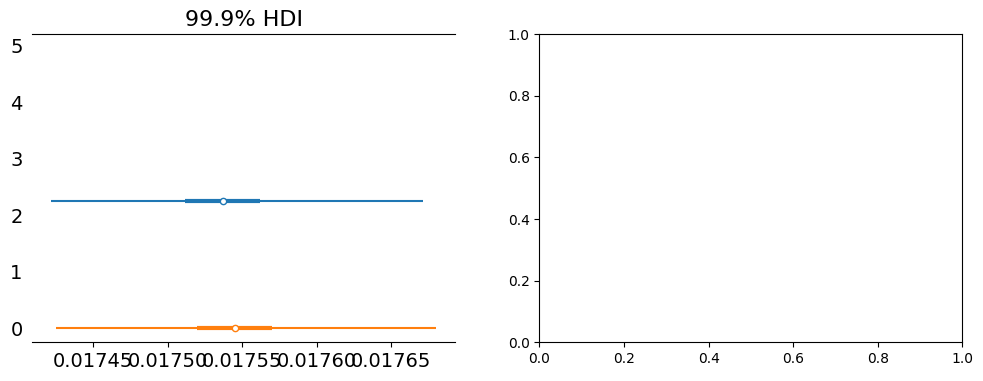

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

az.plot_forest(
    data=[idata_nuts.posterior, idata_svi.posterior], 
    model_names=["NUTS", "SVI"],
    var_names=["beta"],
    ax=ax1,
    combined=True,
    hdi_prob=0.999
)
ax1.vlines(theta["beta"],*ax1.get_ylim(), color="black")

az.plot_forest(
    data=[idata_nuts.posterior, idata_svi.posterior], 
    model_names=["NUTS", "SVI"],
    var_names=["alpha_species"],
    ax=ax2,
    combined=True,
    hdi_prob=0.999
)
ax2.vlines(1,*ax2.get_ylim(), color="black")
ax2.vlines(3,*ax2.get_ylim(), color="black")

plt.tight_layout()

Both models fit a beta value very close to the true value, but are overly confident into their estimate, describing distribution that contain the true value only in the extreme tails of the distribution (0.999 HDI). In addition, the SVI model has problems to estimate the distributions of the alpha_species estimates. This uncertainty is much better covered by the NUTS algorithm.

### Hyper priors on species alpha and experimental variation estimate the variance of the parameter distribution accurately 

There are a few things we will work through to see what makes an unbiased fit of the parameters

+ Use hyperpriors for the hyperprior. Why? Do we really want to find out the alpha parameter for each species in each year, or do we want to find out the underlying alpha parameter for the species in any given year? By specifying hyper priors for the hyper prior, we can get both and on top of that may be able to better estimate the true variation in the data and get better parameter error estimates.
+ Normal prior for the alpha_species parameter. The data for the alpha species level is also drawn from a normal distribution with a single deviation parameter (sigma=0.1). Take a moment to think this through: This means, that the standard deviation of Cottontail is $N(1, 0.1)$ and Jackrabbit is $N(3, 0.1)$. If i now take a lognormal distribution with a constant deviation parameter I run into a problem, because in the lognormal case, the variance of the distribution scales with the scale of the parameter. So $Lognorm(3, 0.1)$ has a wider distribution than $Lognorm(1, 0.1)$. This becomes a real problem, because basically the distribution needs to fit 2 horses under the same roof. We get around this problem by using a normal distribution for the noise, or using different deviation parameters.

We take the liberty of using an unusual approach to specify our model parameters. This is no problem, because of the way the configuration backend is written. Because there are no interdependencies between the sections, we can safely specify our model parameters and then pass them to our configuration as a whole. This little trick will allow us to easily customize our entire posterior, and, more importantly, always specify in the correct order.

In [15]:
# Level 1 Hyperpriors. These are supposed to converge on the true underlying patterns in the data
alpha_species_mu = Param(prior="halfnorm(scale=5)", dims=('rabbit_species',), hyper=True) # type: ignore
alpha_species_sigma = Param(prior="halfnorm(scale=5)", hyper=True) # type: ignore
alpha_sigma = Param(prior="halfnorm(scale=1)", hyper=True) # type: ignore

# Level 2 Hyperpriors
# Here we take the normal distribution in order to get the underlying variation structure right
# note that I also took the liberty of specifying the dimensional order differently, this makes it just a bit
# easier, because indexing of the hyperprior is not necessary.
alpha_species = Param(
    prior="norm(loc=[alpha_species_mu],scale=alpha_species_sigma)", # type: ignore
    hyper=True, dims=("experiment", "rabbit_species",)
) 

# Level 3 Model parameter priors
alpha = Param(prior="lognorm(s=alpha_sigma,scale=alpha_species[experiment_index, rabbit_species_index])", dims=("id",)) # type: ignore
beta = Param(prior="lognorm(s=1,scale=1)") # type: ignore



parameters = Modelparameters(
    alpha_species_mu=alpha_species_mu,
    alpha_species_sigma=alpha_species_sigma,
    alpha_species=alpha_species,
    alpha_sigma=alpha_sigma,

    alpha=alpha,
    beta=beta,

    **sim.config.model_parameters.fixed
)

sim.config.model_parameters = parameters

from pymob.sim.parameters import Expression
sim.config.error_model.wolves.obs_inv = Expression("res*jnp.sqrt(wolves+1e-06)+wolves")
sim.config.error_model.rabbits.obs_inv = Expression("res*jnp.sqrt(rabbits+1e-06)+rabbits")
sim.config.inference.n_predictions = 50

                       Trace Shapes:          
                        Param Sites:          
                       Sample Sites:          
   alpha_species_mu_normal_base dist       2 |
                               value       2 |
alpha_species_sigma_normal_base dist         |
                               value         |
      alpha_species_normal_base dist   3   2 |
                               value   3   2 |
        alpha_sigma_normal_base dist         |
                               value         |
              alpha_normal_base dist     120 |
                               value     120 |
               beta_normal_base dist         |
                               value         |
                    rabbits_obs dist 120  12 |
                               value 120  12 |
                     wolves_obs dist 120  12 |
                               value 120  12 |


100%|██████████| 10000/10000 [04:05<00:00, 40.66it/s, init loss: 95810480.0000, avg. loss [9501-10000]: 4121.1968] 
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:937: UserWarning: Cannot make predictions of observations from normalized observations (residuals). Please provide an inverse observation transform: e.g. `sim.config.error_model['rabbits'].obs_inv = ...`.residuals are denoted as 'res'. See Lotka-volterra case study for an example. 
  warnings.warn(
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:937: UserWarning: Cannot make predictions of observations from normalized observations (residuals). Please provide an inverse observation transform: e.g. `sim.config.error_model['wolves'].obs_inv = ...`.residuals are denoted as 'res'. See Lotka-volterra case study for an example. 
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[0]                         0.968  0.019   0.930    1.003        0.0   
alpha[1]                         1.087  0.016   1.053    1.113        0.0   
alpha[2]                         1.030  0.019   0.996    1.066        0.0   
alpha[3]                         1.055  0.020   1.020    1.094        0.0   
alpha[4]                         1.026  0.015   1.000    1.055        0.0   
...                                ...    ...     ...      ...        ...   
alpha_species[2012, Jackrabbit]  2.937  0.019   2.903    2.972        0.0   
alpha_species_mu[Cottontail]     0.925  0.012   0.904    0.947        0.0   
alpha_species_mu[Jackrabbit]     2.886  0.020   2.848    2.924        0.0   
alpha_species_sigma              0.114  0.008   0.099    0.129        0.0   
beta                             0.018  0.000   0.018    0.018        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
alpha

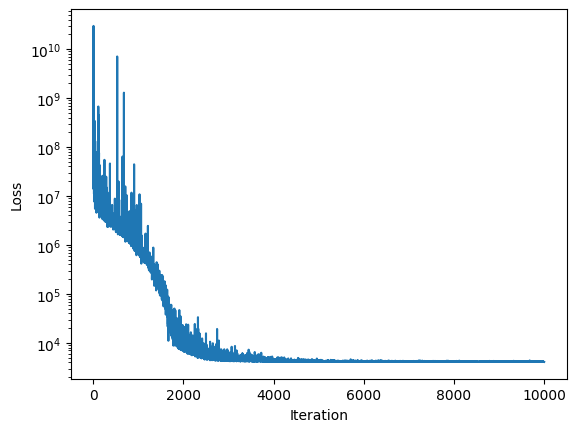

In [30]:
sim.config.inference_numpyro.svi_iterations = 10_000
sim.config.inference_numpyro.svi_learning_rate = 0.0025
sim.dispatch_constructor()
sim.set_inferer("numpyro")

sim.inferer.run()
idata_svi_2 = sim.inferer.idata.copy()

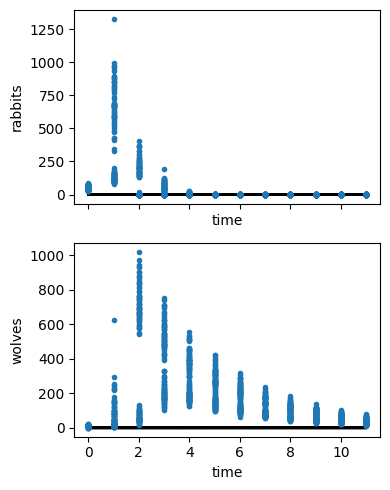

In [ ]:
sim.inferer.error_model = sim.inferer.parse_error_model(sim.config.error_model.all)
sim.posterior_predictive_checks()

In [29]:
loglik, grad_loglik = sim.inferer.create_log_likelihood(return_type="joint-log-likelihood", check=False, vectorize=True, gradients=True)

In [ ]:
sim.inferer.plot_likelihood_landscape(
    ("alpha_species_mu", "beta"),
    log_likelihood_func=loglik, 
    gradient_func=grad_loglik
)

In [36]:
sim.config.model_parameters = parameters
sim.config.inference_numpyro.kernel = "nuts"
sim.config.inference_numpyro.nuts_max_tree_depth = 12
sim.dispatch_constructor()
sim.set_inferer("numpyro")

sim.inferer.run()
idata_nuts_2 = sim.inferer.idata.copy()

                       Trace Shapes:          
                        Param Sites:          
                       Sample Sites:          
   alpha_species_mu_normal_base dist       2 |
                               value       2 |
alpha_species_sigma_normal_base dist         |
                               value         |
      alpha_species_normal_base dist   3   2 |
                               value   3   2 |
        alpha_sigma_normal_base dist         |
                               value         |
              alpha_normal_base dist     120 |
                               value     120 |
               beta_normal_base dist         |
                               value         |
                    rabbits_obs dist 120  12 |
                               value 120  12 |
                     wolves_obs dist 120  12 |
                               value 120  12 |


warmup:   2%|▏         | 68/3000 [13:39<11:35:47, 14.24s/it, 4095 steps of size 3.05e-04. acc. prob=0.73]

In [33]:
idata_svi_2.posterior.beta.mean(("chain", "draw"))

<xarray.DataArray 'beta' ()>
array(0.01758187, dtype=float32)

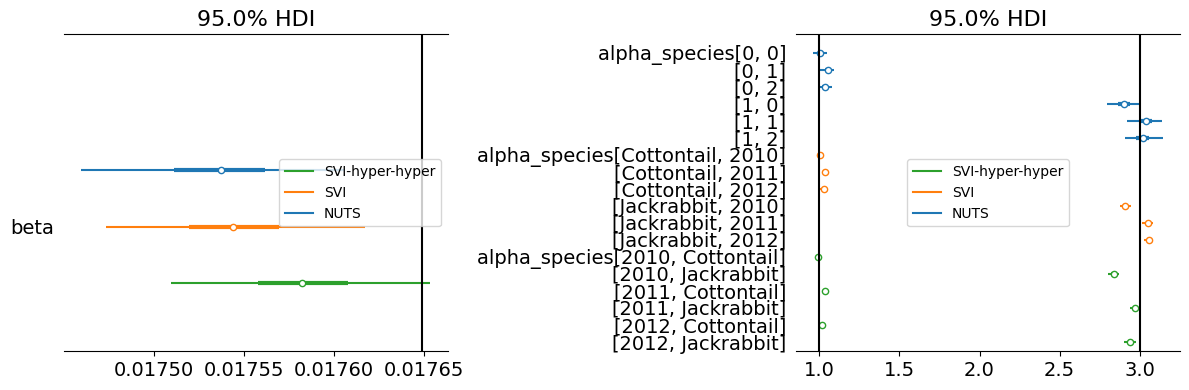

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
az.plot_forest(
    data=[idata_nuts.posterior, idata_svi.posterior, idata_svi_2.posterior], 
    model_names=["NUTS", "SVI", "SVI-hyper-hyper"],
    var_names=["beta"],
    ax=ax1,
    combined=True,
    hdi_prob=0.95
)
ax1.vlines(theta["beta"],*ax1.get_ylim(), color="black")

az.plot_forest(
    data=[idata_nuts.posterior, idata_svi.posterior, idata_svi_2.posterior], 
    model_names=["NUTS", "SVI", "SVI-hyper-hyper"],
    var_names=["alpha_species"],
    ax=ax2,
    combined=True,
    hdi_prob=0.95
)
ax2.vlines(1,*ax2.get_ylim(), color="black")
ax2.vlines(3,*ax2.get_ylim(), color="black")

plt.tight_layout()


**It seems the prior on $\sigma_{alpha}$ was missing**. If the sigma on alpha is included, the fits are slightly improved and the estimates for the species also become better. But also note, with three years, and some considerable variation it is not easy to get the estimate for the species right. I assume, that this model fitted with MCMC will perform better and include the true estimates with higher probability. Also, think it over! These priors describe the underlying relevant feats of the data. The expected growth rates of the rabbit species in general and their yearly variation.

Moreover, 

In [19]:
sim.config.case_study.scenario = "lotka_volterra_hierarchical_hyperpriors"
sim.config.create_directory("scenario")
sim.config.save()

Scenario directory created at '/home/flo-schu/projects/pymob/case_studies/lotka_volterra_case_study/scenarios/lotka_volterra_hierarchical_hyperpriors'.


: 